In [32]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os, sys, datetime as dt, warnings

%matplotlib inline
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.style.use('ggplot')
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
warnings.filterwarnings(action='ignore')

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Load Dataset

In [2]:
df_raw = pd.read_csv('new_jan_1.csv')
df_raw.head()

,taxi_id,trip_seconds,fare,tips,tolls,extras,trip_total,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_minuate,trip_km
0,85.0,180.0,4.50,0.0,0.0,0.0,4.50,199.0,510.0,199.0,510.0,3.0,0.643700
1,4237.0,480.0,7.00,0.0,0.0,0.0,7.00,686.0,500.0,686.0,500.0,8.0,1.770300
2,1987.0,1080.0,17.75,0.0,0.0,0.0,17.75,599.0,346.0,660.0,120.0,18.0,9.977900
3,6400.0,60.0,3.75,0.0,0.0,0.0,3.75,527.0,24.0,527.0,24.0,1.0,0.321900
4,7418.0,180.0,5.00,2.0,0.0,1.5,8.50,210.0,470.0,744.0,605.0,3.0,1.001646


In [3]:
df = df_raw.copy()

# EDA

#### Missing Values

In [4]:
df.isnull().sum()

taxi_id              0
trip_seconds         0
fare                 0
tips                 0
tolls                0
extras               0
trip_total           0
pickup_latitude      0
pickup_longitude     0
dropoff_latitude     0
dropoff_longitude    0
trip_minuate         0
trip_km              0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384038 entries, 0 to 1384037
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   taxi_id            1384038 non-null  float64
 1   trip_seconds       1384038 non-null  float64
 2   fare               1384038 non-null  float64
 3   tips               1384038 non-null  float64
 4   tolls              1384038 non-null  float64
 5   extras             1384038 non-null  float64
 6   trip_total         1384038 non-null  float64
 7   pickup_latitude    1384038 non-null  float64
 8   pickup_longitude   1384038 non-null  float64
 9   dropoff_latitude   1384038 non-null  float64
 10  dropoff_longitude  1384038 non-null  float64
 11  trip_minuate       1384038 non-null  float64
 12  trip_km            1384038 non-null  float64
dtypes: float64(13)
memory usage: 137.3 MB


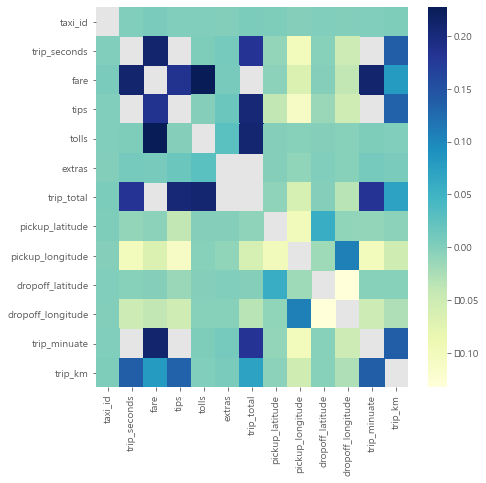

In [6]:
plt.figure(figsize=(7,7))
mask=df.corr() > 0.3
sns.heatmap(df.corr(),cmap='YlGnBu',mask=mask,fmt='.1g')

# Data Preprocessing

In [7]:
df.columns

Index(['taxi_id', 'trip_seconds', 'fare', 'tips', 'tolls', 'extras',
       'trip_total', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude', 'trip_minuate', 'trip_km'],
      dtype='object')

In [8]:
# 불필요 변수 삭제

data = df[['trip_seconds', 'fare', 'tips', 'tolls', 'extras', 'trip_km', 'trip_total']]

X_cols = list(data.columns)
X_cols.remove('trip_total')

In [9]:
X_cols

['trip_seconds', 'fare', 'tips', 'tolls', 'extras', 'trip_km']

In [10]:
X = data[X_cols]
y = data['trip_total']

In [11]:
# Scaling

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X = X_scaler.fit_transform(X)
#y = y_scaler.fit_transform(y.values.reshape(-1,1))

In [12]:
# Train, Test splits

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [13]:
print('Train Set : ', X_train.shape)
print('Test Set : ', X_test.shape)

Train Set :  (968826, 6)
Test Set :  (415212, 6)


# Create Base Model

### Light Gradient Boosting Machine

In [14]:
train_ds = lgb.Dataset(X_train, label=y_train)
val_ds = lgb.Dataset(X_test, label=y_test)

In [27]:
params = {
            'learning_rate' : 0.01,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1
        }

In [28]:
model = lgb.train(params,
                  train_ds,
                  5000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                 )

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29.5611
[200]	valid_0's rmse: 24.3371
[300]	valid_0's rmse: 23.0109
[400]	valid_0's rmse: 22.6454
[500]	valid_0's rmse: 22.4968
Early stopping, best iteration is:
[486]	valid_0's rmse: 22.4828


In [29]:
# 예측
pred = model.predict(X_test)

In [35]:
pred

array([16.06226018,  7.5796911 ,  6.06408164, ...,  6.08492551,
        4.59338493, 37.37658495])

In [34]:
np.sqrt(mean_squared_error(y_test,pred))

22.482772318359093

### Stacking Model

In [17]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
# Train 데이터 설명력
print("Score on training set : {:.3f}".format(rf.score(X_train,y_train)))
print("Score on test set : {:.3f}".format(rf.score(X_test,y_test)))

Score on training set : 0.999
Score on test set : 0.992


In [19]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
# Train 데이터 설명력
print("Score on training set : {:.3f}".format(gb.score(X_train,y_train)))
print("Score on test set : {:.3f}".format(gb.score(X_test,y_test)))

Score on training set : 1.000
Score on test set : 0.986


In [21]:
estimators = [('rf', RandomForestRegressor()),
              ('gb', GradientBoostingRegressor())]

In [26]:
reg = StackingRegressor(estimators=estimators)
reg.fit(X_train, y_train)
# Train 데이터 설명력
print("Score on training set : {:.3f}".format(reg.score(X_train,y_train)))
print("Score on test set : {:.3f}".format(reg.score(X_test,y_test)))

KeyboardInterrupt: 

In [97]:
# build model
Stacking_Model = StackingRegressor(estimators=estimators)

labels = y_train
features = X_train

# Fit the RF model with features and labels.
st_reg=Stacking_Model.fit(features, labels)

In [98]:
# 모델 실행 및 결과 확인
X_test_predict=pd.DataFrame(
    reg.predict(X_test)).rename(
    columns={0:'predict'})
X_train_predict=pd.DataFrame(
    reg.predict(X_train)).rename(
    columns={0:'predict'})

# combine the training and testing dataframes to visualize
# and compare.
SR_predict = X_train_predict.append(X_test_predict)

In [99]:
st_reg.predict(X_test)

array([29.43432893, 30.48592358, 28.71953962, 27.26175094, 27.15735104,
       27.84288857, 28.61703119, 29.00198937, 25.7586136 , 25.58833178,
       25.81642875, 24.88627266, 23.23354193, 22.6783895 ])